https://alphaarchitect.com/2020/02/26/reinforcement-learning-for-trading/
This site shows how agent performs on simple sinusoidal representation of market, and then with added noise
Try straight lines and see how quickly agent learns to always buy or always sell
Random Walks

Try logistic regression to give buy sell hold signals with $\alpha$ and $1-\alpha$ as cutoffs for those signals
e.g. <0.1 or >0.9

In [242]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import os
import numpy as np

SELL, HOLD, BUY = -1, 0, 1
PRICES, POSITION, BALANCE = 0, 1, 2
MONTHS = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8}
INSTRUMENTS = ['AUDJPY', 'AUDNZD', 'AUDUSD', 'CADJPY', 'CHFJPY', 'EURCHF', 'EURGBP', 'EURJPY', 'EURPLN', 'EURUSD', 
               'GBPJPY', 'GBPUSD', 'NZDUSD', 'USDCAD', 'USDCHF', 'USDJPY', 'USDMXN', 'USDRUB', 'USDTRY', 'USDZAR']

def load_data(months=MONTHS, instruments=INSTRUMENTS):
    '''
    Inputs:
        months      - list of month names (as strings with full names e.g. ['February', 'March', 'April'])
        instruments - list of instruments to be loaded in for those months e.g. ['CADJPY', 'EURUSD']
    Outputs:
        data        - list of dataframes, one for each instrument in the same order as in `instruments`
    '''
    data = []
    
    for instr in instruments:
        df = pd.DataFrame()
        for month in months:
            i = MONTHS[month]
            new = pd.read_csv(os.getcwd() + f'\data\\{month}\\{instr}-2020-0{i}\\{instr}-2020-0{i}.csv', header=None)
            df = pd.concat([df, new], axis=0)
        
        df.columns = ['instrument', 'date', 'bid', 'ask']
        df = df.drop('instrument', axis=1)
        df.date = pd.to_datetime(df.date)
        data.append(df)
        
    # I have chosen to return a list of dataframes since the date doesn't line up
    return data

data = load_data(['January'], ['GBPUSD'])[0]

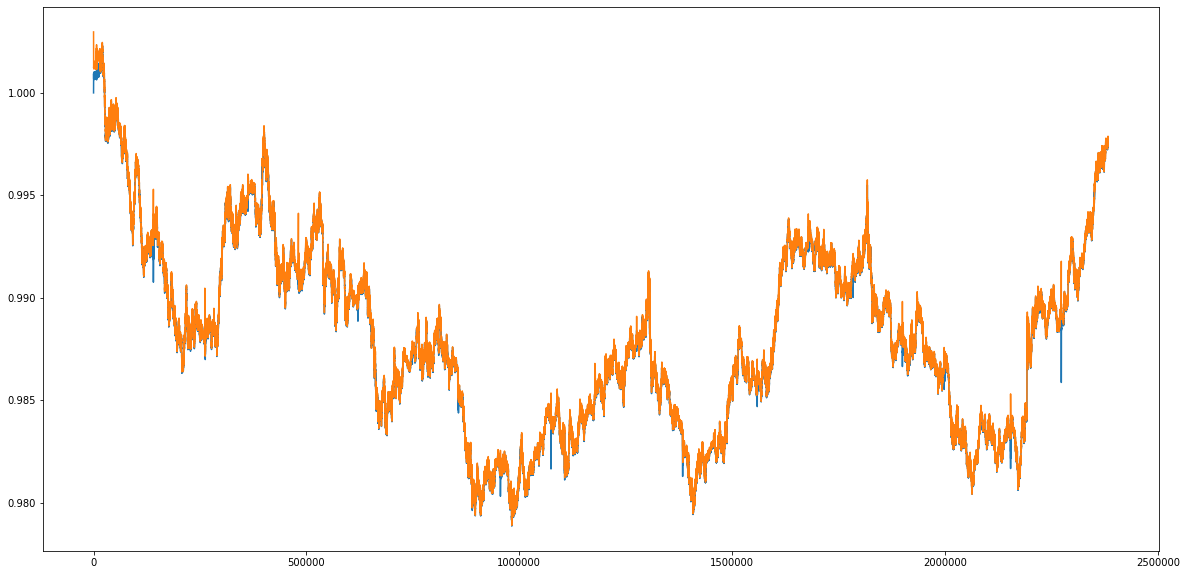

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data['bid']/data['bid'].iloc[0])
ax.plot(data['ask']/data['bid'].iloc[0])
plt.show()

In [666]:
class Agent:
    
    def load(self, path):
        """ Load in agent from path """
        raise NotImplementedError()

    def save(self, path):
        """ Save the agent to path """
        raise NotImplementedError()

    def get_action(self, state, **kwargs):
        """ Get an action for the given state """
        raise NotImplementedError()

    def train(self, n_steps, n_episodes, save_every, save_path, **kwargs):
        """ Train the agent """
        raise NotImplementedError()
        
class RandomAgent(Agent):
    
    def get_action(self, state):
        """ Get a target action for the given state. 
        This means if the current state is buy, and the action is buy nothing will happen. """
        return np.random.choice([BUY, SELL, HOLD])   

class BuyAndHold(Agent):
    
    def get_action(self, state):
        """ Get a target action for the given state. 
        This means if the current state is buy, and the action is buy nothing will happen. """
        return BUY  
    
class SellAndHold(Agent):
    
    def get_action(self, state):
        """ Get a target action for the given state. 
        This means if the current state is buy, and the action is buy nothing will happen. """
        return SELL
    
class Environment:
    
    def __init__(self, data, balance, transaction_cost=0.001, i=0, position=0):
        self.data = data
        self.i = i
        self.transaction_cost = transaction_cost
        self.state = [self.data[:self.i+1], position, balance]
        self.accumulated_reward = 0
    
    def get_transaction_cost(self, action):
        ''' Returns cost of transaction '''
        # If the action matches the current position
        if action == self.state[POSITION]:
            return 0
        
        # If the action moves the position by one
        if abs(action - self.state[POSITION]) == 1:
            return self.transaction_cost
        
        # If the action flips from buy to sell vice versa
        return 2*self.transaction_cost
    
    def step(self, action):
        ''' Updates environment with action taken, returns new state and reward from state transition '''
        prior_portfolio_value = self.get_portfolio_value()
        curr_price = self.state[PRICES][-1]
        
        # Perform position transition
        self.state[BALANCE] -= curr_price*abs(action - self.state[POSITION])*self.transaction_cost
        
        # A Buy
        if (action == BUY and self.state[POSITION] == HOLD) or (action == HOLD and self.state[POSITION] == SELL):
            self.state[BALANCE] -= curr_price
        
        # A Sell
        elif (action == SELL and self.state[POSITION] == HOLD) or (action == HOLD and self.state[POSITION] == BUY):
            self.state[BALANCE] += curr_price
            
        # Flip Position
        elif abs(action - self.state[POSITION]) == 2:
            self.state[BALANCE] -= 2 * action * curr_price
        
        # Update historical data
        self.i += 1
        self.state[PRICES].append(self.data[self.i])
        self.state[POSITION] = action
        
        # Calculate reward
        reward = round(self.get_portfolio_value() - prior_portfolio_value, 8)
        self.accumulated_reward += reward
        
        return self.state, reward, self.accumulated_reward
    
    def get_portfolio_value(self):
        ''' Returns current portfolio value '''
        curr_price = self.state[PRICES][-1]
        
        if self.state[POSITION] == BUY:
            return self.state[BALANCE] + curr_price
        elif self.state[POSITION] == SELL:
            return self.state[BALANCE] - curr_price
        return self.state[BALANCE]
    
    def get_state(self):
        ''' Returns the current state '''
        return state
    
    def __repr__(self):
        curr_price = self.state[PRICES][-1]
        return f'Balance: ${self.state[BALANCE]}, Position: {self.state[POSITION]}, Prices: {curr_price}'

env = Environment(list(np.round(data.bid, 6)), 100)
env

Balance: $100, Position: 0, Prices: 1.32343

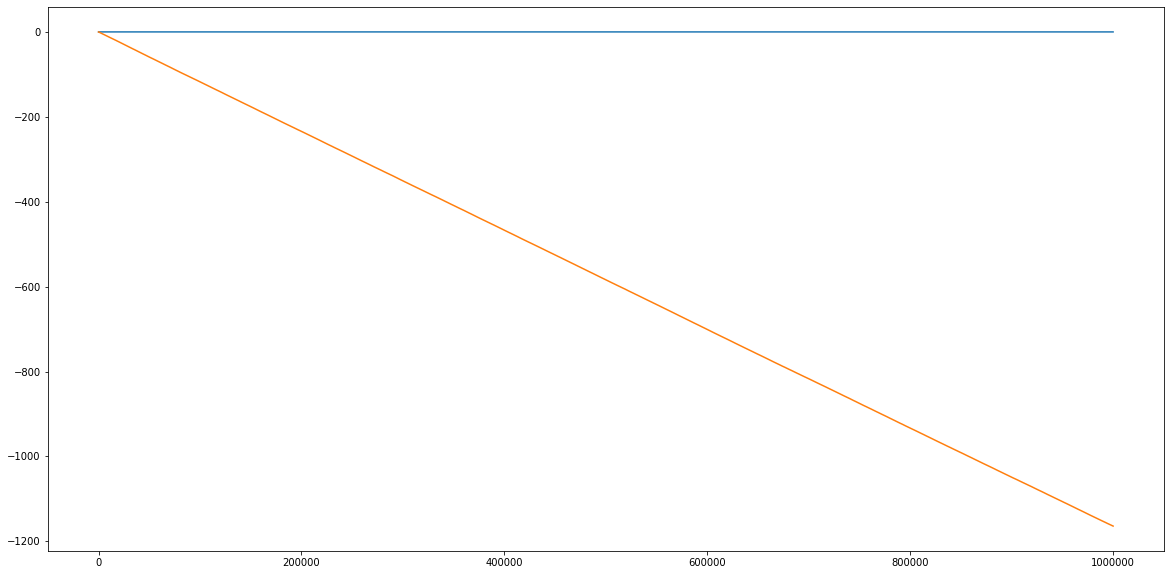

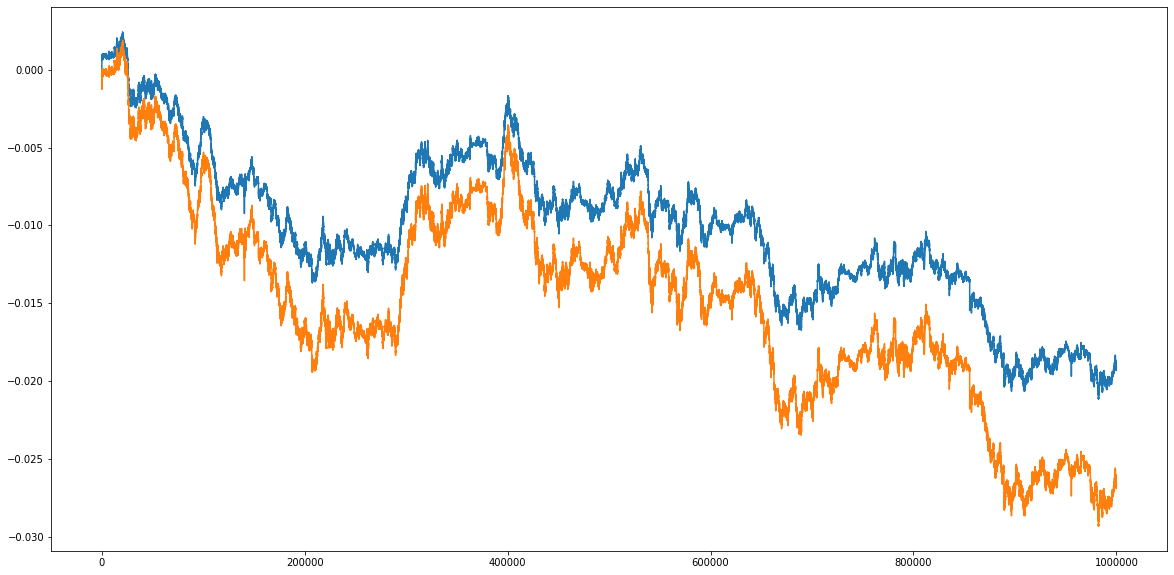

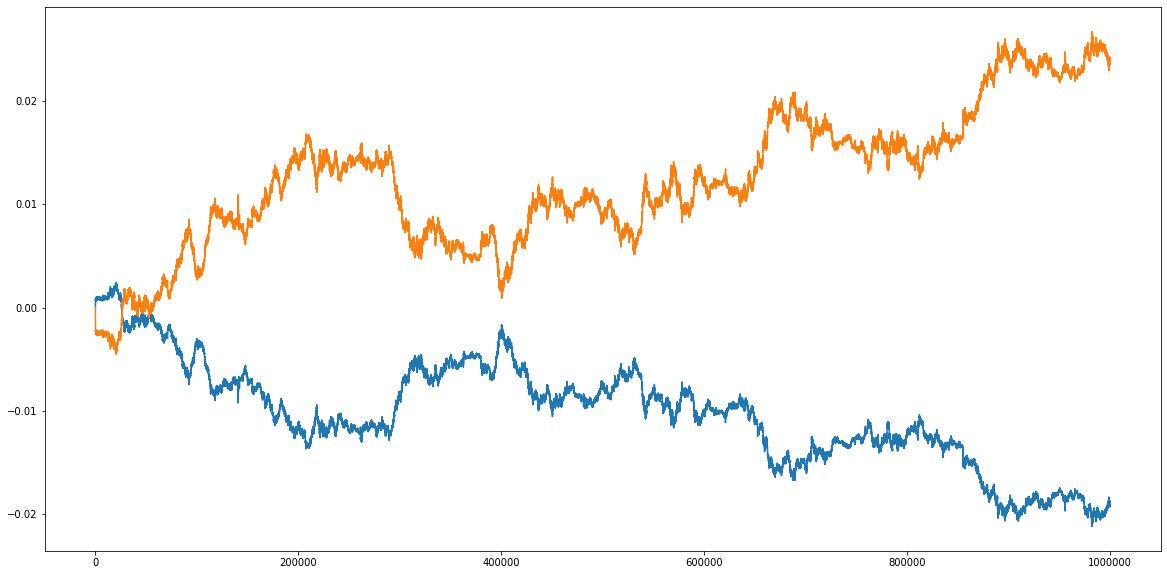

In [669]:
def simulation(agent, env, n_ticks=1_000_000):
    accumulated_rewards = [0]
    
    for i in range(n_ticks):
        action = agent.get_action(env.state)
        state, reward, accumulated_reward = env.step(action)
        accumulated_rewards.append(accumulated_reward)
    
    prices = np.array(state[PRICES])
    accumulated_rewards = np.array(accumulated_rewards)
        
    return prices / prices[0] - 1, (accumulated_rewards + 1) / (accumulated_rewards + 1)[0] - 1

# Random Agent
fig, ax = plt.subplots(figsize=(20, 10))
env = Environment(list(np.round(data.bid, 6)), 100)
prices, accumulated_rewards = simulation(RandomAgent(), env)
ax.plot(prices)
ax.plot(accumulated_rewards)
plt.show()

# Buy and Hold
fig, ax = plt.subplots(figsize=(20, 10))
env = Environment(list(np.round(data.bid, 6)), 100)
prices, accumulated_rewards = simulation(BuyAndHold(), env)
ax.plot(prices)
ax.plot(accumulated_rewards)
plt.show()

# Sell and Hold
fig, ax = plt.subplots(figsize=(20, 10))
env = Environment(list(np.round(data.bid, 6)), 100)
prices, accumulated_rewards = simulation(SellAndHold(), env)
ax.plot(prices)
ax.plot(accumulated_rewards)
plt.show()